In [1]:
import requests        # Needs to be installed (pip install requests)
import json
import pandas as pd    # Needs to be installed (pip install pandas)

In [2]:
url = 'https://v1.api.covindia.com/covindia-raw-data'
raw_data = requests.get(url=url).json()
# Next line is just to change the type of keys from string to int
# This is required for making the dataframe automatically
raw_data = {int(old_key): val for old_key, val in raw_data.items()}
#print(raw_data)

In [3]:
raw_data_df = pd.DataFrame.from_dict(raw_data, orient='index')
raw_data_df  = raw_data_df [['date','time','district','state','infected','death','source']]
raw_data_df["date"] = pd.to_datetime(raw_data_df["date"],dayfirst=True)
raw_data_df.to_csv('raw_data.csv', index = False)
raw_data_df.head()

,date,time,district,state,infected,death,source
0,2020-02-03,0:00,Kannur,Kerala,1,0,http://dhs.kerala.gov.in/%e0%b4%a1%e0%b5%86%e0...
1,2020-03-02,0:00,Delhi,Delhi,1,0,https://en.wikipedia.org/wiki/2020_coronavirus...
2,2020-03-02,0:00,Delhi,Delhi,5,0,https://en.wikipedia.org/wiki/2020_coronavirus...
3,2020-03-02,0:00,Delhi,Delhi,1,0,https://en.wikipedia.org/wiki/2020_coronavirus...
4,2020-03-02,19:53,Hyderabad,Telangana,5,0,NA


In [4]:
state_day_df = raw_data_df.groupby(['date', 'state'], as_index=False)['infected','death'].sum()
state_day_df.head(-1)

<ipython-input-4-ca2b6da117ac>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  state_day_df = raw_data_df.groupby(['date', 'state'], as_index=False)['infected','death'].sum()


,date,state,infected,death
0,2020-02-03,Kerala,1,0
1,2020-03-02,Delhi,7,0
2,2020-03-02,Telangana,5,0
3,2020-03-04,Haryana,14,0
4,2020-03-04,Rajasthan,1,0
...,...,...,...,...
1518,2020-05-27,Assam,4,0
1519,2020-05-27,Nagaland,5,0
1520,2020-05-27,Orissa,76,0
1521,2020-05-27,Rajasthan,109,2


,date,state,infected,death
11,2020-03-10,Maharashtra,5,0
13,2020-03-11,Maharashtra,1,0
15,2020-03-12,Maharashtra,9,0
21,2020-03-13,Maharashtra,2,0
23,2020-03-14,Maharashtra,18,0
...,...,...,...,...
1384,2020-05-22,Maharashtra,2940,63
1413,2020-05-23,Maharashtra,2608,60
1444,2020-05-24,Maharashtra,3041,58
1473,2020-05-25,Maharashtra,2436,60


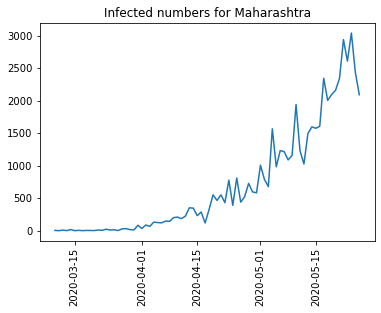

In [6]:
from matplotlib import pyplot as plt
maharashtra_df = state_day_df[state_day_df['state']=='Maharashtra']
#maharashtra_df  = maharashtra_df.sort_values('date', ascending=True)
plt.plot(maharashtra_df['date'], maharashtra_df['infected'])
plt.xticks(rotation='vertical')
plt.title('Infected numbers for Maharashtra')
maharashtra_df

In [6]:
def cleanDf(mrdf):
    mrdf = mrdf.drop(['state','death'],axis=1)
    mrdf['date'] = pd.to_datetime(mrdf['date'])
    mrdf = mrdf.groupby(mrdf.date.dt.date)["infected"].sum()
    mrdf = pd.DataFrame(mrdf)
    return mrdf
mdf = cleanDf(maharashtra_df)
mrdf = mdf


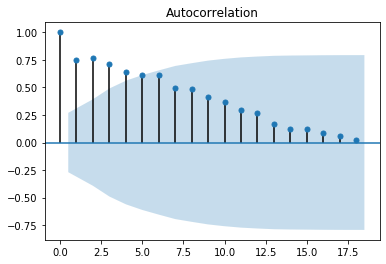

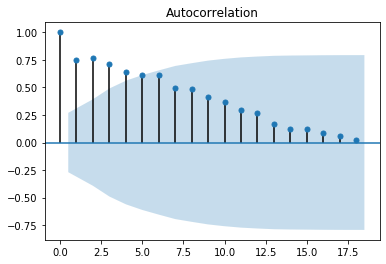

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(mrdf.head(100)) # graph is not deivating meaning stationary, no trend or seasonality.

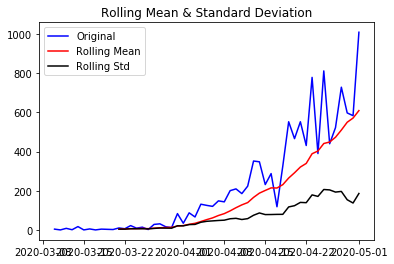

In [8]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
test_stationarity(mrdf)

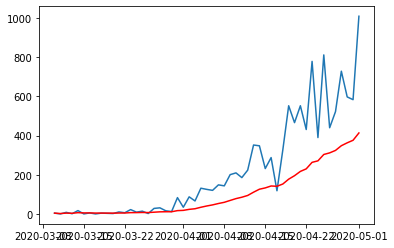

In [9]:
exponentialDecayWeightedAverage = mrdf.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(mrdf)
plt.plot(exponentialDecayWeightedAverage, color='red')

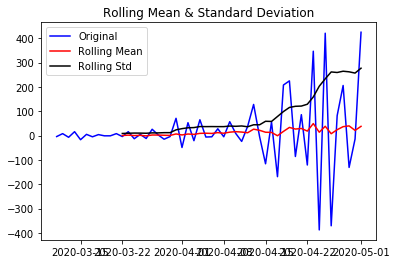

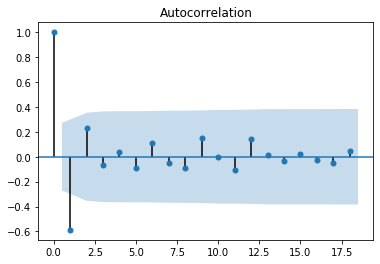

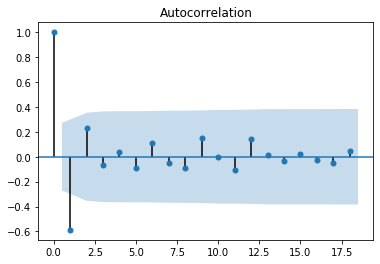

In [10]:

datasetLogDiffShifting = mrdf -  mrdf.shift(periods=1)
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)
plot_acf(datasetLogDiffShifting)

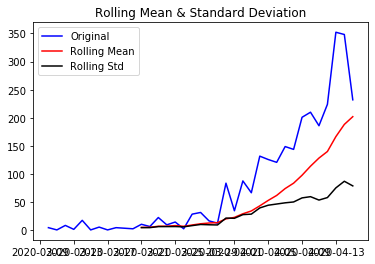

In [11]:
mrdfs = datasetLogDiffShifting
train = mrdf[:int(0.7*(len(mrdf)))]
test = mrdf[int(0.7*(len(mrdf))):]
test_stationarity(train)

In [12]:
from pmdarima import auto_arima
def trainState(mrdf):
    train = mrdf[1:int(0.7*(len(mrdf)))]

    model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
    return model,train

C:\Users\varun\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\varun\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=349.888, BIC=359.220, Fit time=0.514 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=358.815, BIC=361.926, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=359.312, BIC=363.978, Fit time=0.104 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=356.526, BIC=361.192, Fit time=0.133 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=359.589, BIC=367.366, Fit time=0.557 seconds
Fit ARIMA: order=(3, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=351.460, BIC=362.348, Fit time=0.644 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=357.539, BIC=365.316, Fit time=0.246 seconds
Fit ARIMA: order=(2, 1, 3) seasonal_order=(0, 0, 0, 1); AIC=351.135, BIC=362.023, Fit time=0.503 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=358.247, BIC=364.468, Fit time=0.340 seconds
Fit ARIMA: order=(3, 1, 3) seasonal_order=(0, 0, 0, 1);

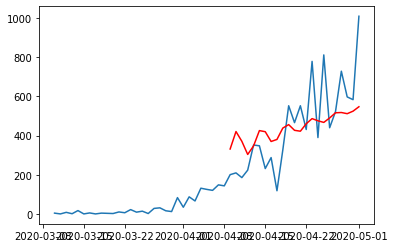

In [13]:
def statepred(mrdf):
    totest = mrdf[30:]
    
    model,train = trainState(mrdf)
    results_ARIMA = model.fit(train)
    forecast = model.predict(n_periods=len(totest))
    forecast = pd.DataFrame(forecast,index = totest.index,columns=['Prediction'])
    plt.plot(mrdf)
    plt.plot(forecast, color='red')
    print('Plotting ARIMA model')
statepred(mrdf)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=285.767, BIC=294.561, Fit time=0.336 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=289.752, BIC=292.683, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=284.950, BIC=289.347, Fit time=0.026 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=283.840, BIC=288.237, Fit time=0.045 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=283.325, BIC=289.188, Fit time=0.205 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=287.658, BIC=294.986, Fit time=0.129 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=284.435, BIC=291.764, Fit time=0.278 seconds
Total fit time: 1.041 seconds
Plotting ARIMA model


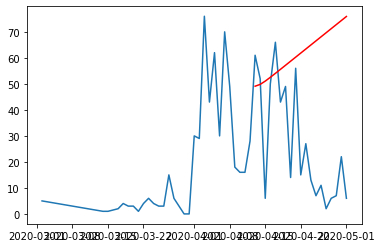

In [14]:
tdf = state_day_df[state_day_df['state']=='Telangana']
tdf = cleanDf(tdf)
statepred(tdf)